## Compare performance, usability and accuracy of XGBoost and LGBM

note XGBooting can not handle categorical features without converting the features to numeric values (one-hot encoding)

Based on the sample data set, XGBoost provides more accurate predictions with higher variance than LGBM which has obviously faster performance

In [76]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### data set

In [52]:
boston = load_boston()
print (boston.keys())
print (boston.data.shape)
print (boston.feature_names)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [53]:
df_data = pd.DataFrame(boston.data)
df_data.columns = boston.feature_names
df_data['PRICE'] = boston.target
df_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [54]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [ ]:
# prepare data
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X, y = df_data.iloc[:,:-1],df_data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### XGBoost

In [112]:
# fit model and tune parameter

import xgboost as xgb
from sklearn.model_selection import GridSearchCV 
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth =5,
                          alpha = 10, 
                          n_estimators = 10,
                          verbosity = 0,
                          random_state=123)

test_params = {
 'max_depth':[1,2,5],
 'n_estimators':[10,20,50]   
    
}

model = GridSearchCV(estimator = xg_reg, param_grid = test_params)
model.fit(X_train,y_train)
print ("parameter selected:",model.best_params_)

parameter selected: {'max_depth': 5, 'n_estimators': 50}


In [141]:
# train and fit
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth =5,
                          alpha = 10, 
                          n_estimators = 50)
xg_reg.fit(X_train,y_train)

rmse_train: 2.291346363453096
rmse_test: 4.147070836699256


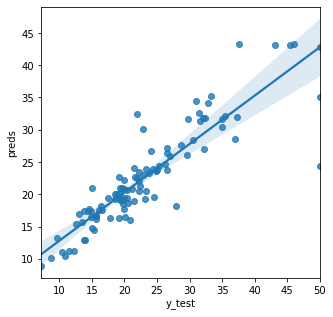

In [144]:
# evaluate

import seaborn as sns
preds_test = xg_reg.predict(X_test)
preds_train = xg_reg.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
print (f"rmse_train: {rmse_train}\nrmse_test: {rmse_test}")
eval = {'y_test' : y_test, 'preds' : preds}
df_eval = pd.DataFrame(eval)
ax = sns.regplot(x="y_test", y="preds", data=df_eval)

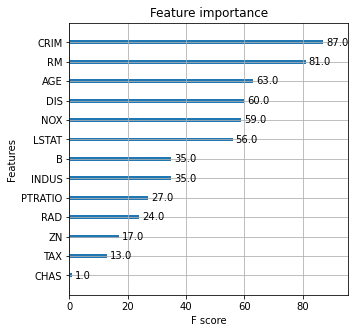

In [115]:
# check feature importance

import matplotlib.pyplot as plt
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### LightGBM

In [134]:
import lightgbm as lgb

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 3,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100
}
gbm = lgb.LGBMRegressor(**hyper_params)

In [135]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=100)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100, num_leaves=128,
              objective='regression', task='train', verbose=0)

rmse_train: 6.4355712898343045
rmse_test: 6.739049563425224


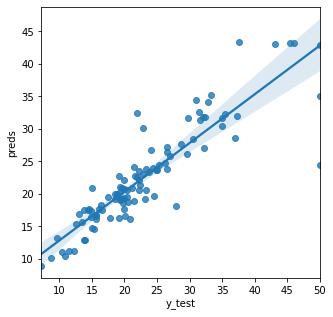

In [146]:
# evaluate

import seaborn as sns
preds_train = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
preds_test = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
print (f"rmse_train: {rmse_train}\nrmse_test: {rmse_test}")
eval = {'y_test' : y_test, 'preds' : preds}
df_eval = pd.DataFrame(eval)
ax = sns.regplot(x="y_test", y="preds", data=df_eval)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

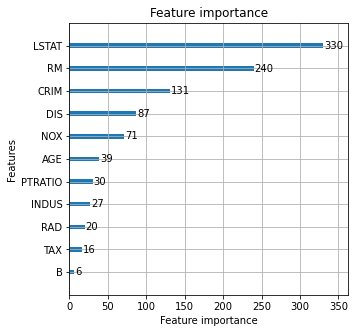

In [164]:
# check feature importance
lgb.plot_importance(gbm)